## Chapter 3 평가

분류의 성능 평가 지표: 정확도(Accuracy), 오차행렬(Confusion Matrix), 정밀도(Precision), 재현율(Recall), F1 스코어, ROC AUC

## 1. 정확도(Accuracy)

- 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표

- 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

- 이진 분류의 경우 데이터의 구성에 따라 ML모델의 성능을 왜곡할 수 있기 떄문에 정확도 수치 하나만 가지고 성능을 평가하지 않음.

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  # fit() 메서드는 아무것도 학습하지 않음.
  def fit(self,X,y=None):
    pass
  # predict() 메서드는 단순히 Sex 피치가 1이면 0, 그렇지 않으면 1로 예측함.
  def predict(self,X):
    pred=np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i]=0
      else:
        pred[i]=1
    return pred

In [2]:
from google.colab import files
myfile = files.upload()

Saving titanic_train.csv to titanic_train.csv


In [4]:
# 이전에 처리한 코드
from sklearn import preprocessing

def fillna(df):
  df['Age'].fillna(df['Age'].mean(),inplace=True)
  df['Cabin'].fillna('N',inplace=True)
  df['Embarked'].fillna('N',inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'],axis=1, inplace=True)
  return df

def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df,y_titanic_df,test_size=0.2,random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
mypredictions=myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

# 단순한 알고리즘으로 예측을 하였음에도 정확도가 높음 -> 정확도 평가 지표의 맹점

Dummy Classifier의 정확도는: 0.7877


- 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님.

 ex. 100개의 데이터 중 90개의 데이터 레이블이 0, 10개의 데이터 레이블이 1이라면, 무조건 0으로 예측 결과를 반환하는 ML모델의 경우라도 정확도는 90%가 됨.

In [13]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self,X,y):
    pass

  # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits=load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data,y,random_state=11)

# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:',y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf=MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


- 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용하면 안됨.

- 정확도가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 함.

## 2. 오차 행렬

- 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지를 함께 보여주는 지표

- 정확도 = (TN+TP)/(TN+FP+FN+TP) -> TN과 TP의 좌우됨.

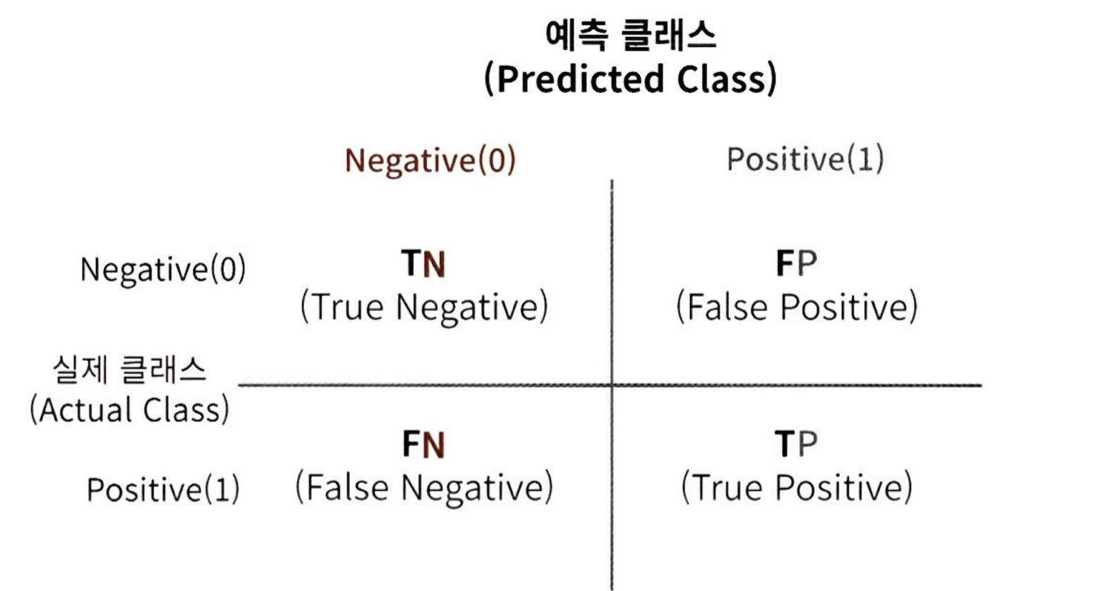

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,fakepred)

array([[405,   0],
       [ 45,   0]])

- 불균형한 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘은 Positive보다는 Negative로 예측 정확도가 높아지는 경향이 발생함.

## 3. 정밀도와 재현율

- Positive 데이터 세트의 예측 성능에 더 초점을 맞춘 평가 지표

- 앞서 만든 MyFakeClassifier는 Positive로 예측한 TP값이 하나도 없어 정밀도와 재현율의 값은 0

- 정밀도 (양성 예측도) = TP / (FP + TP) : 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율

- 재현율 (민감도,TPR) = TP / (FN + TP) : 실제 값이 Positive인 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율

- 재현율이 중요 지표인 경우) 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우

 ex. 암 판단 모델, 금융 사기 적발 모델

 - 정밀도가 중요 지표인 경우) 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
 
  ex. 스팸메일 여부를 판단하는 모델 

In [16]:
# 평가를 간편하게 적용하기 위해 confusion_matrix, accuracy, precision, recall 등의 평가를 한번에 호출하는 get_clf_eval() 함수 만들기

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  print("오차 행렬")
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf=LogisticRegression()

lr_clf.fit(X_train,y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test,pred)
# 정밀도에 비해 재현율이 낮음. -> 강화 필요

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## 정밀도 / 재현율 트레이드오프

- 분류하려는 업무 특성상 정밀도 또는 재현율이 특별히 강조되어야 하는 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음. 

- 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면, 다른 수치는 떨어짐.

- 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구하고, 예측 확률이 큰 레이블값으로 예측하게 됨. 일반적으로 이진 분류에서는 이 임계값을 0.5 즉 50%로 정하고 이 기준 값보다 확률이 크면 Positive, 작으면 Negative로 결정

### predict_proba() 메서드

입력 파라미터) 

predict() 메서드와 동일하게 보통 테스트 피처 데이터 세트를 입력

반환 값)
 
개별 클래스의 예측 확률을 ndarray m*n (m: 입력 값의 레코드 수, n: 클래스 값 유형) 형태로 반환

각 열은 개별 클래스의 예측 확률. 이진 분류에서 첫 번째 열은 0 Negative의 확률, 두 번째 열은 1 Positive의 확률

predict()는 predict_proba() 메서드가 반환하는 확률 값을 가진 ndarray에서 정해진 임곗값을 만족하는 ndarray의 칼럼 위치를 최종 에측 클래스로 결정

In [33]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출: \n',pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출: 
 [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


### Binarizer 클래스

threshold 변수를 특정 값으로 설정하고 Binarizer 클래스를 객체로 생성. 생성된 Binarizer 객체의 fit_transform()메서드를 이용해 넘파이 ndarray를 입력하면 입력된 ndarray의 값을 지정된 threshold보다 같거나 작으면 0값으로, 크면 1값으로 변환해 반환.

In [34]:
from sklearn.preprocessing import Binarizer

X=[[1,-1,2],
   [2,0,0],
   [0,1.1,1.2]]
# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [35]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임계값
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Posiive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [39]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉, 분류 결정 임계값을 0.5에서 0.4로 낮춤.
custom_threshold=0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

# 임계값을 낮추니 재현율은 올라가고 정밀도는 떨어짐.

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


- 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준 -> 임곗값을 낮추면 Positive 예측을 더 너그럽게 하기 때문에 임곗값 값을 낮출수록 True값이 많아지게 됨.

- 분류 결정 임곗값이 낮아질수록 Positive로 예측할 확률이 높아짐. 재현율 증가

In [40]:
# 임곗값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가 지표 조사

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds=[0.4,0.45,0.5,0.55,0.6]

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
  # thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:',custom_threshold)
    get_clf_eval(y_test,custom_predict)

get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


### precision_recall_curve()

입력 파라미터)

y_true: 실제 클래스값 배열 (배열 크기=[데이터 건수])

probas_pred: Positive 칼럼의 예측 확률 배열 (배열 크기=[데이터 건수])

반환 값) 정밀도, 재현율

In [42]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index = np.arange(0,thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개 :', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index],3))

# 임곗값이 증가할수록 정밀도 값은 동시에 높아지나 재현율 값은 낮아짐.

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임곗값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도 :  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율 :  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


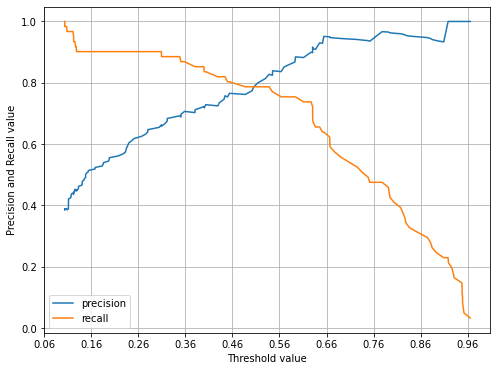

In [46]:
# 정밀도와 재현율 곡선 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test,pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='-',label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

  # threshold 값 X축의 scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value')
  plt.ylabel('Precision and Recall value')
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

# 임곗값이 낮을수록 많은 수의 양성 예측으로 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아짐.

### 정밀도와 재현율의 맹점

임곗값의 변경은 업무 환경에 맞게 2개의 수치를 상호 보완할 수 있는 수준에서 적용되어야 함. 정밀도, 재현율 평가 지표 수치 중 하나를 극단적으로 높이는 방법은 숫자 놀음에 불과

### 정밀도 100% 가 되는 방법

확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측

### 재현율 100%가 되는 방법

모든 환자를 Positive로 예측하면 됨.

-> 어느 한쪽만 참조하면 극단적인 수치 조작 가능

## 4. F1 스코어

- 정밀도와 재현율을 결합한 지표

- 정밀도와 재현율이 어느 한쪽으로 치우치지 않은 수치를 나타낼 때 상대적으로 높은 값을 가짐.

In [47]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [49]:
# 임곗값을 변화시키면서 F1스코어를 포함한 평가 지표 구하기

def get_clf_eval(y_test, pred): 
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  #F1 스코어 추가
  f1 = f1_score(y_test, pred)

  print('오차행렬')
  print(confusion)

  # F1 score print 추가  
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

# f1 score는 임곗값이 0.6일 때 가장 좋은 값을 보여주지만, 재현율은 크게 감소

임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율:0.8361, F1 : 0.7727
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492, 정밀도 : 0.7656, 재현율:0.8033, F1 : 0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율:0.7869, F1 : 0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659, 정밀도 : 0.8364, 재현율:0.7541, F1 : 0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771, 정밀도 : 0.8824, 재현율:0.7377, F1 : 0.8036


## 5. ROC 곡선과 AUC

- 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표

- ROC 곡선(Receiver Operation Characteristic Curve): FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate, 재현율)이 어떻게 변하는지 나타내는 곡선

- 민감도 (TPR): 실제값 Positive가 정확히 예측되어야 하는 수준

- 특이성 (TNR): 실제값 Negative가 정확히 예측되어야 하는 수준 

TNR = TN / (FP + TN)

FPR = FP / (FP + TN) = 1-특이성

- ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어짐.

In [50]:
from sklearn.metrics import roc_curve

# 레이블값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 스텝으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨, 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개 : ', thr_index)
print('샘플용 10개의 임곗값 : ', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개 :  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값 :  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


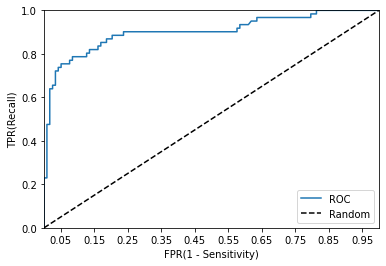

In [51]:
def roc_curve_plot(y_test, pred_proba_c1):

  # 임곗값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)

  # ROC 곡선을 그래프 곡서능로 그림
  plt.plot(fprs, tprs, label='ROC')

  # 가운데 대각선 직선 그림
  plt.plot([0,1],[0,1],'k--', label='Random')

  # FPR X 축의 Scale을 0.1 단위로 변경, X,Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xlabel('FPR(1 - Sensitivity)')
  plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

In [52]:
def get_clf_eval(y_test, pred=None, pred_proba=None): # 평가 한번에 호출하는 함수
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)

  print('오차행렬')
  print(confusion)
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))